# FDU PRML 2024 Fall Assignment 2

Name: `<your name>`

Student ID: `<your student id>`

Image classification is a basic task in computer vision and deep learning. The CIFAR-10 dataset serves as a critical benchmark for testing and understanding neural network architectures, particularly convolutional neural networks (CNNs).

In this assignment, we revisit the traditional task of CIFAR-10 image classification. You will use PyTorch (or any other framework you like) to initialize ResNet-18, a lightweight yet powerful neural network model, and train it on the CIFAR-10 dataset. You will identify the weaknesses of the training process and propose solutions to improve the model's performance. Finally, you will visualize the model's convolutional filters and try to interpret the results.

You may not use pretrained ResNet-18 checkpoints.

## 1. Data Preparation

Training data is very important if you want your model to have good performance. Bad training data will result in "Garbage in, garbage out." But simply getting the data "correct" is not good enough. You need to do data augmentation to further improve performance.

For reference, you may want to use these techniques:
1. Random Horizontal Flip
2. Random Crop
3. Cutmix https://arxiv.org/abs/1905.04899
4. Mixup https://arxiv.org/abs/1710.09412

You can always try more data augmentation techniques. Not all will work, but some of them will definitely help.

In [ ]:
from tqdm.autonotebook import tqdm as tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_device_name())

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
transform = transforms.Compose([
    # You might want to augment data here by flipping, rotating, etc.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=test_transform)

# Split train into train and validation
trainset_size = int(0.8 * len(trainset))
valset_size = len(trainset) - trainset_size
trainset, valset = torch.utils.data.random_split(trainset, [trainset_size, valset_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, pin_memory=True, num_workers=8)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=True, pin_memory=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, pin_memory=True, num_workers=8)

## 2. Model Initialization and Training

You need to tune the hyperparameters of the model to achieve the best performance. For example, you might want to adjust the learning rate, batch size, and optimizer. You can also try different initialization methods, or add regularization techniques like dropout or batch normalization.

You can make slight adjustments to the ResNet-18 architecture, but the parameter size should stay roughly the same (or less).

In [ ]:
model = torchvision.models.resnet18().to(device) # Don't use pretrained checkpoints

# You might want to tune the hyperparameters or add regularization
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)

loss_list = []
epoch_loss_list = []
train_acc_list = []
val_acc_list = []
best_model = None
num_epochs = 200

model.train()
pbar = tqdm(total=num_epochs)
train_acc = 0
val_acc = 0
for i in range(num_epochs):
    pbar.set_description_str(f"Training")
    model.train()
    for j, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    pbar.update(1)
    pbar.set_description_str(f"Evaluating {i}/{num_epochs}")
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels).item()
            epoch_loss_list.append(loss)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = correct / total
        train_acc_list.append(train_acc)
        correct = 0
        total = 0
        for j, (images, labels) in enumerate(valloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_acc = correct / total
        val_acc_list.append(val_acc)
        if val_acc >= max(val_acc_list):
            best_model = copy.deepcopy(model.state_dict())
        pbar.set_postfix_str(f"Train {train_acc} Validation {val_acc} Loss {loss}")
    scheduler.step()
pbar.close()

## 3. Plot Training Curves and Test Accuracy

Training curves are essential for understanding the training process. You should plot the training loss and accuracy to see whether the model is overfitting, underfitting, or converging.

In [ ]:
# Plot loss and accuracy
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.title('Loss')
plt.xlabel('Step')
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Training")
plt.plot(val_acc_list, label="Validation")
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

Test accuracy is used to evaluate the model's performance on unseen data. You should not use the test set for model selection or hyperparameter tuning.

**The baseline test accuracy is 87%. You should aim to achieve a test accuracy of at least 90%.**

In [ ]:
# Test accuracy
model.load_state_dict(best_model)
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in tqdm(testloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print('Test Accuracy: {} %'.format(100 * accuracy))

## 4. Visualization of Convolutional Filters

Convolutional filters are the core components of CNNs. You should visualize the convolutional filters of the trained model to (try to) understand what the model has learned. Although it might be difficult to interpret the filters directly, you can still observe some patterns.

An example of visualized convolutional filters in one layer is shown below. You should try to visualize the filters of different layers and compare them.

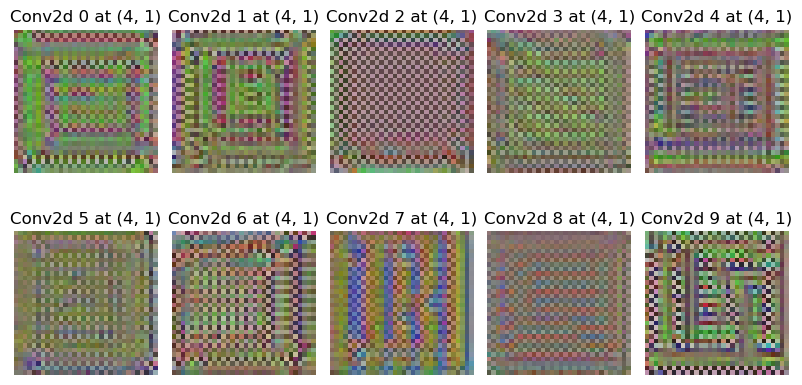